---

# CSCI 3352, Spring 2022
# FINAL PROJECT

<br> 

### Owen Smith, Kyle Ma

<br> 

In [1]:
import os
import random
import pprint
import numpy as np
import pandas as pd
import networkx as nx
import math
import matplotlib
import matplotlib.pylab as plt
from sklearn import tree
from pyvis.network import Network
import csv

In [2]:
### ITERATE THROUGH NETWORKS DIRECTORY, HANDLE FILES ###
directory = 'networks'
for filename in os.scandir(directory):
    filename = filename.name
    name, ext = os.path.splitext(filename)
    ext = str(ext)[0:4]
    if ext == '.csv' and filename != 'references.csv':
        data = np.loadtxt(open(directory + '/' + filename, "rb"), delimiter=",", skiprows=1)
        edgelist = ''
        listfile = open(directory + '/' + filename[:-4] + '.txt', 'w')
        for row in range(0, len(data)):
            for col in range(0, len(data[row])):
                if data[row][col] != 0:
                    edgelist = edgelist + str(col) + ' ' + str(row) + '\n'
        d = listfile.write(edgelist)
        listfile.close()

In [3]:
# takes in a graph G and returns a list of network statistics
def gather_network_stats(G):
    def compute_MGD(G):
        path = list((dict(nx.all_pairs_shortest_path_length(G)).values())) #takes return and converts to list of dicts
        Z = 0
        l_sum = 0

        for node in path:
            tmp = list(node.values()) #convert node dict to list of values
            tmp.remove(0) #remove all instances of 0
            Z = Z + len(tmp) #calculate Z from size of list
            l_sum = l_sum + sum(tmp) #add all the path lengths to the total for the numerator later on

        MGD = l_sum / Z
        return MGD
    
    def percent_single_degree(G): #gets percentage of nodes with degree of one, as these edge suggest specialized predation
        degrees = dict(G.degree())
        degrees = list(degrees.values())
        single_degree_count = 0
        for k in degrees:
            if k == 1 or k == 2:
                single_degree_count += 1
        return single_degree_count / G.number_of_nodes()

    def count_FFBL_motifs(G,flag):
        FFL_count = 0
        FBL_count = 0

        ### MY CODE ###
        FFL_pairs = [] #lists that will contain pairs for later printing if flag == 1
        FBL_pairs = []

        for i in G.nodes(): #loop for suggested enumeration
            for j in G.neighbors(i): #paths of length 1
                for k in G.neighbors(j): #paths of length 2
                    if (i != k): #eliminate bidirectionals
                        if (G.has_edge(i, k)): #if there is an edge from i -> k, it is a FFL
                            FFL_count += 1
                            FFL_pairs.append(((i,j), (j,k), (i,k)))
                        if (G.has_edge(k, i)): #if there is an edge from k -> i, it is a FBL
                            FBL_count += 1
                            FBL_pairs.append(((i,j), (j,k), (k,i)))

        FBL_count = int(FBL_count / 3) #divide FBL_count by 3 to retroactively account for duplicates

        if (flag == 1): #print flag
            for i in FFL_pairs:
                print("FFL: ", i)
            FBL_pairs = FBL_pairs[::3] #takes every third element to get rid of duplicates (kinda jank but it works)
            for i in FBL_pairs:
                print("FBL:", i)

        return (FFL_count,FBL_count)
    
    n = G.number_of_nodes() #builtin function that returns number of nodes as an int
    m = G.number_of_edges() #builtin funciton that reutnrs number of edges as an int
    
    degrees = dict(G.degree())
    totalDegrees = sum(degrees.values()) #get values, sum, divide by number of nodes
    kmean =  totalDegrees / n #calculate mean
    
    degree_lst = list(degrees.values())
    kmax = max(degree_lst)
    
    C = nx.transitivity(G)
    node_connectivity = nx.node_connectivity(G)
    MGD = compute_MGD(G)
    FFL_count, FBL_count = count_FFBL_motifs(G, 0)
    FFL_count = FFL_count / n
    FBL_count = FBL_count / n
    specialized_nodes = percent_single_degree(G)
    
    percent_cannibal = 0
    for node in G.nodes():
        if node in G.neighbors(node):
            percent_cannibal += 1
    percent_cannibal = percent_cannibal / n
    return [n, m, kmean, kmax, C, node_connectivity, MGD, FFL_count, FBL_count, specialized_nodes, percent_cannibal]

In [4]:
def get_temp(filename):
    # returns temperature as a float
    df = pd.read_csv("our_references.csv")
    temp = df[["Filename", "Temperature"]]
    temperature = temp.loc[temp["Filename"] == filename,"Temperature"].iloc[0]
    return float(temperature)

In [5]:
def get_correlation_coefficients(data_array):
    # returns correlation coefficients as a list
    df = pd.DataFrame(data_array, columns = ['network', "nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD', 
                                             'FFL', 'FBL', 'special nodes', 'percent_cannibal', 'Temperature'])
    correlations = df.corr()['Temperature'][:-1]
    print(df)
    return correlations #this line for returning as dataframe
    #return correlations.to_numpy()

In [6]:
# iterates through networks directory and reads each in as networkx graph G
directory = 'networks'
data = []
show = True
for filename in os.scandir(directory):
    filename = filename.name
    name, ext = os.path.splitext(filename)
    ext = str(ext)[0:4]
    if ext == '.txt' and filename != 'README':
        G = nx.read_edgelist(directory + '/' + filename, create_using=nx.DiGraph)
        network_stats = [filename]
        network_stats = network_stats + gather_network_stats(G)
        network_stats.append(get_temp(filename[:-4]))
        data.append(network_stats)
        if filename == "FW_003.txt" or filename == "FW_006.txt":
            species = pd.read_csv("species/"+ filename[:-4] + ".csv").columns[1:]
            mapping = {}
            for i, a in enumerate(G.nodes()):
                mapping[a] = species[int(a)]
#                 print(len(G.nodes()))
#                 print(len(species))
                a = species[int(a)]
                #print(a)
            H = nx.relabel_nodes(G, mapping)
            stats = gather_network_stats(G)
            #nx.draw(H, with_labels = True)
            net = Network(notebook = True)
            net = Network('2000px', '2000px', directed = True)
            net.from_nx(H)
            labels = ["nodes", "number of edges", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD', 
                                             'FFL', 'FBL', 'special nodes', 'percent cannibal']
            for i, a in enumerate(stats):
                print(labels[i], ': ', a)
            for edge in net.edges:
                edge['label'] = ''
            net.show("test" + filename[3:-4] + ".html")
            show = False

nodes :  26
number of edges :  125
average degrees :  9.615384615384615
highest degree :  20
Cluster Coeff :  0.3758503401360544
connectivity :  0
MGD :  2.401666666666667
FFL :  9.923076923076923
FBL :  2.0384615384615383
special nodes :  0.11538461538461539
percent cannibal :  0.11538461538461539
nodes :  30
number of edges :  225
average degrees :  15.0
highest degree :  32
Cluster Coeff :  0.26447016918967053
connectivity :  0
MGD :  1.9350132625994696
FFL :  23.733333333333334
FBL :  3.3333333333333335
special nodes :  0.03333333333333333
percent cannibal :  0.2


In [7]:
get_correlation_coefficients(data)

          network  nodes  degrees  average degrees  highest degree  \
0      FW_001.txt     39      183         9.384615              26   
1      FW_002.txt     11       36         6.545455              11   
2      FW_003.txt     26      125         9.615385              20   
3      FW_004.txt     32      137         8.562500              19   
4      FW_005.txt     43      409        19.023256              54   
5      FW_006.txt     30      225        15.000000              32   
6      FW_007.txt     42      219        10.428571              20   
7      FW_008.txt    247     3301        26.728745             199   
8      FW_009.txt     37      237        12.810811              34   
9      FW_010.txt     35      247        14.114286              42   
10     FW_011.txt     71      338         9.521127              50   
11  FW_012_01.txt     37      120         6.486486              26   
12  FW_012_02.txt     44      145         6.590909              32   
13  FW_013_01.txt   

nodes               0.357052
degrees             0.209314
average degrees    -0.159898
highest degree      0.391070
Cluster Coeff       0.212016
connectivity        0.267024
MGD                -0.277938
FFL                -0.297519
FBL                -0.254127
special nodes       0.029932
percent_cannibal   -0.171546
Name: Temperature, dtype: float64

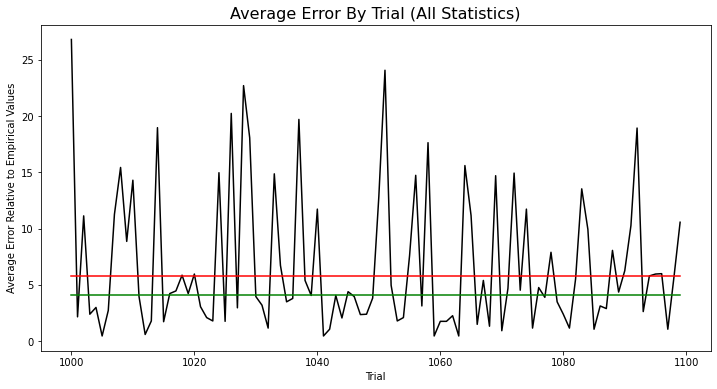

Mean error across all runs: 5.795453333333333
Median error across all runs: 4.066666666666667
{0: 0.4527777777777807,
 1: -0.3996555683122882,
 2: 6.899785867237683,
 3: 4.3261006289308215,
 4: 3.4066298342541477,
 5: 1.3353005464480916,
 6: 4.5576381365113745,
 7: 26.294816414686828,
 8: 5.25133876600698,
 9: 8.686907216494843,
 10: -8.266186252771623,
 11: -6.431344902386116,
 12: 0.025896860986546918,
 13: -0.4287862513426439,
 14: -0.9199533255542596,
 15: 0.5842760180995471,
 16: 2.0931744312026,
 17: 1.719735391400217,
 18: -1.5814189189189165,
 19: -1.4155154091392121,
 20: -1.3943783783783772,
 21: -2.069437939110068,
 22: 1.2586636466591148,
 23: 1.0822905620360492,
 24: 0.7198208286674112,
 25: 0.6238888888888874,
 26: -14.42409638554217,
 27: 25.029102844638945,
 28: 5.691956521739133,
 29: -3.6495555555555583,
 30: 14.315094339622643,
 31: -5.9400826446281005,
 32: -3.9279956427015197}


In [13]:
df = pd.DataFrame(data, columns = ['network', "nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD',
                                   'FFL', 'FBL', 'special nodes', 'percent cannibal', 'Temperature'])
X = df[["nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 
        'MGD', 'FFL', 'FBL', 'special nodes', 'percent cannibal']]
y = df['Temperature']

num_trials = 10000
rand_set = list(range(0, 33))
rand_set_track = list(range(0, 33))
average_errors = []
X = X.to_numpy()
y = y.to_numpy()
empirical_net = {}
for trial in range(0, num_trials):
    # create lists and generate random indeces for training from global dataset
    errors = []
    empirical_set = []
    training_set = []
    empirical_set_temps = []
    training_set_temps = []
    training_set_indeces = np.random.choice(rand_set, size = 30, replace=False)
    rand_set_track = [val for val in rand_set if val not in training_set_indeces]
    #print(rand_set_track)
    # append generated values to respective sets
    for index in training_set_indeces:
        training_set.append(X[index])
        training_set_temps.append(y[index])
    for index in rand_set_track:
        empirical_set.append(X[index])
        empirical_set_temps.append(y[index])
    # machine learning regression tree
    ML = tree.DecisionTreeRegressor(criterion='mse')
    ML.fit(training_set, training_set_temps)
    for index in range(0, len(empirical_set_temps)):
        prediction = ML.predict([empirical_set[index]])
        errors.append(abs(empirical_set_temps[index] - prediction))
        if rand_set_track[index] in empirical_net:
            empirical_net[rand_set_track[index]].append((empirical_set_temps[index] - prediction)[0])
        else:
            #print("here")
            empirical_net[rand_set_track[index]] = (empirical_set_temps[index] - prediction).tolist()
    average_errors.append(np.mean(errors))
for i in empirical_net:
    empirical_net[i] = np.mean(empirical_net[i])
error_axis = list(range(0, len(average_errors)))
median = [np.median(average_errors) for i in range(10000)]
mean = [np.mean(average_errors) for i in range(10000)]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(error_axis[1000:1100], average_errors[1000:1100], color = 'black')
ax.plot(error_axis[1000:1100], mean[1000:1100], color = 'r', label = "Mean Error")
ax.plot(error_axis[1000:1100], median[1000:1100], color = 'g', label = "Median Error")
ax.set_title("Average Error By Trial (All Statistics)", fontsize=16)
ax.set_xlabel("Trial")
ax.set_ylabel("Average Error Relative to Empirical Values")
plt.show()
print("Mean error across all runs:", np.mean(average_errors))
print("Median error across all runs:", np.median(average_errors))
pprint.pprint(empirical_net)

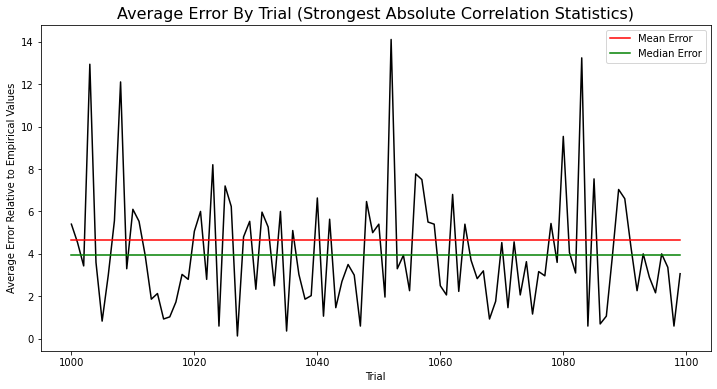

Mean error across all runs: 4.640443333333332
Median error across all runs: 3.93333333333333
{0: -0.42775956284152694,
 1: -2.3362239297475336,
 2: 6.252316384180787,
 3: 5.612960893854751,
 4: 8.075693673695898,
 5: 0.7425458715596382,
 6: 4.413950892857142,
 7: 3.105465116279072,
 8: 9.890879478827358,
 9: 12.835351351351349,
 10: -7.461613958560533,
 11: -6.8887931034482754,
 12: -1.7074316939890712,
 13: -0.9827548806941435,
 14: -1.1052401746724894,
 15: 0.4418947368421043,
 16: 0.15027027027026965,
 17: 0.4231532524807042,
 18: -1.4871874999999979,
 19: -1.2549883990719244,
 20: -1.4586245772266049,
 21: -2.3636363636363615,
 22: 1.3124324324324297,
 23: 1.2479545454545384,
 24: -0.23303370786516764,
 25: 0.3020044543429832,
 26: -14.666910229645095,
 27: 4.970550847457623,
 28: 5.941576673866093,
 29: 2.3480984340044695,
 30: 14.9665544332211,
 31: -7.608531317494602,
 32: -3.9332951945080037}


In [12]:
df = pd.DataFrame(data, columns = ['network', "nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD',
                                   'FFL', 'FBL', 'special nodes', 'percent cannibal', 'Temperature'])
X = df[["nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity']]
y = df['Temperature']

num_trials = 10000
rand_set = list(range(0, 33))
rand_set_track = list(range(0, 33))
average_errors = []
X = X.to_numpy()
y = y.to_numpy()
empirical_net = {}
for trial in range(0, num_trials):
    # create lists and generate random indeces for training from global dataset
    errors = []
    empirical_set = []
    training_set = []
    empirical_set_temps = []
    training_set_temps = []
    training_set_indeces = np.random.choice(rand_set, size = 30, replace=False)
    rand_set_track = [val for val in rand_set if val not in training_set_indeces]
    #print(rand_set_track)
    # append generated values to respective sets
    for index in training_set_indeces:
        training_set.append(X[index])
        training_set_temps.append(y[index])
    for index in rand_set_track:
        empirical_set.append(X[index])
        empirical_set_temps.append(y[index])
    # machine learning regression tree
    ML = tree.DecisionTreeRegressor(criterion='mse')
    ML.fit(training_set, training_set_temps)
    for index in range(0, len(empirical_set_temps)):
        prediction = ML.predict([empirical_set[index]])
        errors.append(abs(empirical_set_temps[index] - prediction))
        if rand_set_track[index] in empirical_net:
            empirical_net[rand_set_track[index]].append((empirical_set_temps[index] - prediction)[0])
        else:
            #print("here")
            empirical_net[rand_set_track[index]] = (empirical_set_temps[index] - prediction).tolist()
    average_errors.append(np.mean(errors))
for i in empirical_net:
    empirical_net[i] = np.mean(empirical_net[i])
error_axis = list(range(0, len(average_errors)))
median = [np.median(average_errors) for i in range(10000)]
mean = [np.mean(average_errors) for i in range(10000)]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(error_axis[1000:1100], average_errors[1000:1100], color = 'black')
ax.plot(error_axis[1000:1100], mean[1000:1100], color = 'r', label = "Mean Error")
ax.plot(error_axis[1000:1100], median[1000:1100], color = 'g', label = "Median Error")
ax.legend()
ax.set_title("Average Error By Trial (Strongest Absolute Correlation Statistics)", fontsize=16)
ax.set_xlabel("Trial")
ax.set_ylabel("Average Error Relative to Empirical Values")
plt.show()
print("Mean error across all runs:", np.mean(average_errors))
print("Median error across all runs:", np.median(average_errors))
pprint.pprint(empirical_net)

[2.366666666666665, 3.266666666666668, 0.9333333333333323, 4.066666666666667, 4.900000000000001, 3.0333333333333337, 0.9333333333333323, 2.233333333333332, 1.533333333333329, 3.6666666666666643, 1.6666666666666643, 0.9333333333333323, 5.966666666666666, 2.9000000000000057, 2.633333333333333, 7.36666666666667, 2.3999999999999964, 2.1666666666666665, 1.7999999999999996, 5.5, 4.466666666666666, 9.333333333333329, 8.0, 11.866666666666665, 6.166666666666664, 0.9333333333333348, 4.466666666666669, 3.099999999999999, 2.599999999999999, 3.233333333333332, 2.0333333333333337, 0.9333333333333323, 0.13333333333333286, 13.5, 8.133333333333333, 2.566666666666665, 2.8333333333333286, 11.233333333333329, 7.033333333333331, 5.399999999999996, 2.1333333333333306, 5.166666666666669, 6.866666666666663, 14.533333333333337, 3.5666666666666678, 19.333333333333332, 7.933333333333327, 4.2, 3.066666666666665, 3.999999999999998, 14.466666666666669, 3.033333333333329, 3.5999999999999965, 0.4666666666666662, 6.79

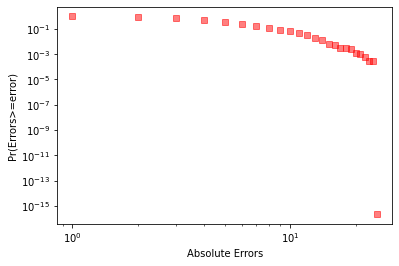

In [10]:
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(math.ceil(kmax)+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Absolute Errors')
    plt.ylabel('Pr(Errors>=error)')
    plt.show()
    return
print(average_errors)
plot_CCDF(average_errors)

In [11]:
plot_CCDF(empirical_net.values())

TypeError: '<' not supported between instances of 'dict_values' and 'int'